In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import os
import matplotlib.pyplot as plt

# ======================
# 1. Load and Preprocess Data
# ======================
def load_and_preprocess():
    # Load data
    train = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.parquet")
    test = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.parquet")
    df = pd.concat([train, test])
    
    # Preprocessing
    df = df.drop(columns=['id', 'attack_cat'], errors='ignore')
    cat_cols = ['proto', 'service', 'state']
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    
    X = df.drop('label', axis=1)
    y = df['label']
    
    # Scale numerical features
    num_cols = X.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])
    
    return X, y

X, y = load_and_preprocess()


In [2]:
# ======================
# 2. Experiment Setup
# ======================
ratios = [
    (10, 90), (20, 80), (30, 70), 
    (40, 60), (50, 50), (60, 40),
    (70, 30), (80, 20), (90, 10)
]

results = {}
os.makedirs('saved_models', exist_ok=True)

In [3]:
# ======================
# 3. Training and Evaluation(Random Forest)
# ======================
for train_ratio, test_ratio in ratios:
    print(f"\n=== Training with {train_ratio}:{test_ratio} split ===")
    
    # Split data (stratified for labeled portion)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_ratio/100, 
        stratify=y,
        random_state=42
    )
    
    # Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    # Evaluate
    y_pred = rf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store results
    results[f"{train_ratio}:{test_ratio}"] = {
        'model': rf,
        'accuracy': report['accuracy'],
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_1': report['1']['f1-score']
    }
    
    # Save model
    joblib.dump(rf, f'saved_models/rf_{train_ratio}_{test_ratio}.joblib')
    print(f"Model saved for {train_ratio}:{test_ratio} split")



=== Training with 10:90 split ===
Model saved for 10:90 split

=== Training with 20:80 split ===
Model saved for 20:80 split

=== Training with 30:70 split ===
Model saved for 30:70 split

=== Training with 40:60 split ===
Model saved for 40:60 split

=== Training with 50:50 split ===
Model saved for 50:50 split

=== Training with 60:40 split ===
Model saved for 60:40 split

=== Training with 70:30 split ===
Model saved for 70:30 split

=== Training with 80:20 split ===
Model saved for 80:20 split

=== Training with 90:10 split ===
Model saved for 90:10 split


In [4]:
# ======================
# 4. Results Analysis
# ======================
# Create results dataframe
results_df = pd.DataFrame.from_dict(results, orient='index')

# Save results to CSV
results_df.to_csv('/kaggle/working/model_results.csv')
print("\nResults saved to model_results.csv")

# Save models and results in Kaggle's working directory
os.makedirs('/kaggle/working/saved_models', exist_ok=True)
for ratio, result in results.items():
    train_ratio = ratio.split(':')[0]
    joblib.dump(result['model'], f'/kaggle/working/saved_models/rf_{train_ratio}.joblib')

# Create zip archive of results
import zipfile
with zipfile.ZipFile('/kaggle/working/models_and_results.zip', 'w') as zipf:
    zipf.write('/kaggle/working/model_results.csv')
    for file in os.listdir('/kaggle/working/saved_models'):
        zipf.write(f'/kaggle/working/saved_models/{file}')


Results saved to model_results.csv


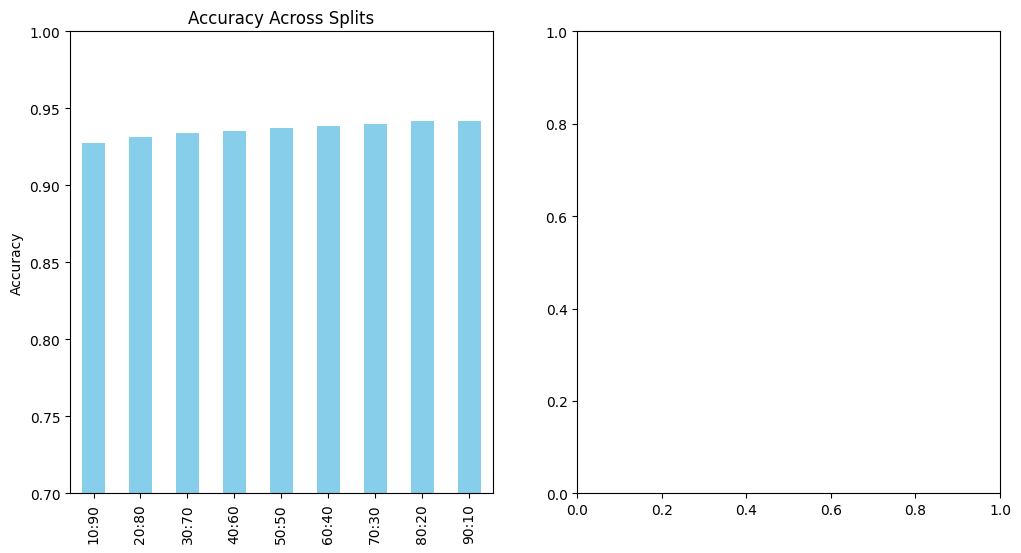

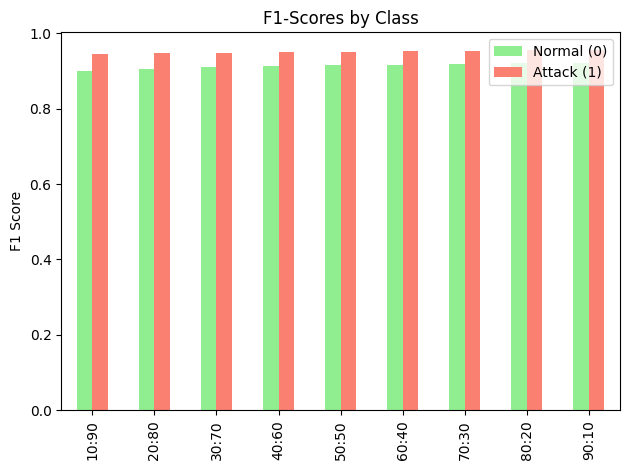


=== Performance Summary ===
       accuracy      f1_0      f1_1
10:90  0.927626  0.899521  0.943445
20:80  0.931614  0.905720  0.946349
30:70  0.933937  0.909045  0.948131
40:60  0.935636  0.911511  0.949424
50:50  0.937580  0.914279  0.950921
60:40  0.938653  0.915890  0.951720
70:30  0.939562  0.917131  0.952436
80:20  0.941535  0.919890  0.953971
90:10  0.942021  0.920625  0.954331


In [5]:
# ======================
# 5. Visualization
# ======================
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
results_df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Accuracy Across Splits')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)

# F1-Score comparison
plt.subplot(1, 2, 2)
results_df[['f1_0', 'f1_1']].plot(kind='bar', color=['lightgreen', 'salmon'])
plt.title('F1-Scores by Class')
plt.ylabel('F1 Score')
plt.legend(['Normal (0)', 'Attack (1)'])

plt.tight_layout()
plt.savefig('/kaggle/working/results_comparison.png')
plt.show()

# Print summary table
print("\n=== Performance Summary ===")
print(results_df[['accuracy', 'f1_0', 'f1_1']])